# Case Study 3

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

import cmath
import math
import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm
import scipy.interpolate as interp
from scipy import interpolate
from scipy.optimize import fmin, fmin_bfgs

## 0. Define parameters

Based on the Case Study 1, we can take the same values of alpha and eta. As we considered the data from April 18 2023, the spot price this day was $4,112.23.

In [2]:
S0 = 4112.23
alpha = 1.5
eta = 0.2

By using the USD rates from 'https://www.global-rates.com/en/', we interpolate and find a value of r = 0.049452.

For the dividens we use the following formula: Call(T) – Put(T)  =   Spot . exp{- dividend . T} -  Strike . exp{-rate . T}. By isolating the dividend, we find q = 0.0159. I used the call and put prices define after in the notebook.

In [3]:
r = 0.049452
q = 0.0159

## 1. Import data and preprocessing

Let us import the data from 'https://www.cboe.com/delayed_quotes/spx/quote_table'. Here it corresponds to the data from April 18 2023 to June 30 2023.

In [4]:
df = pd.read_csv('spx_quotedata.csv',index_col = 0)

In [5]:
df

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
Expiration Date,,,,,,,,,,,,,,,,,,,,,
Tue Apr 18 2023,SPXW230418C01000000,0.00,0.00,0.00,0.00,0,0.0000,0.0000,0.0,0,...,SPXW230418P01000000,0.00,0.0,0.0,0.0,0,0.0000,0.0000,0.0,0
Tue Apr 18 2023,SPXW230418C01200000,0.00,0.00,0.00,0.00,0,0.0000,0.0000,0.0,0,...,SPXW230418P01200000,0.00,0.0,0.0,0.0,0,0.0000,0.0000,0.0,0
Tue Apr 18 2023,SPXW230418C01400000,0.00,0.00,0.00,0.00,0,0.0000,0.0000,0.0,0,...,SPXW230418P01400000,0.00,0.0,0.0,0.0,0,0.0000,0.0000,0.0,0
Tue Apr 18 2023,SPXW230418C01600000,0.00,0.00,0.00,0.00,0,0.0000,0.0000,0.0,0,...,SPXW230418P01600000,0.00,0.0,0.0,0.0,0,0.0000,0.0000,0.0,0
Tue Apr 18 2023,SPXW230418C01800000,0.00,0.00,0.00,0.00,0,0.0000,0.0000,0.0,0,...,SPXW230418P01800000,0.10,0.0,0.0,0.0,0,0.0000,0.0000,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fri Jun 30 2023,SPXW230630C05100000,0.10,-0.05,0.05,0.25,1,0.1523,0.0018,0.0,245,...,SPXW230630P05100000,0.00,0.0,906.3,911.4,0,0.1662,-0.9992,0.0,0
Fri Jun 30 2023,SPXW230630C05200000,0.10,0.00,0.00,0.20,0,0.1601,0.0013,0.0,209,...,SPXW230630P05200000,1040.00,0.0,1005.2,1010.3,0,0.1756,-0.9997,0.0,1
Fri Jun 30 2023,SPXW230630C05300000,0.45,0.00,0.00,0.15,0,0.1689,0.0010,0.0,226,...,SPXW230630P05300000,0.00,0.0,1104.0,1109.3,0,0.1826,-1.0000,0.0,5


### 1.1 Call options

Let us create the callPrices dataframe. 

In [6]:
callPrices = df[['Last Sale','Strike','Ask','Bid']]
callPrices["Mid"] = callPrices[['Bid', 'Ask']].mean(axis=1)

# Convert dates to correct format
callPrices.index = pd.to_datetime(callPrices.index)

In [7]:
callPrices

,Last Sale,Strike,Ask,Bid,Mid
Expiration Date,,,,,
2023-04-18,0.00,1000,0.00,0.00,0.000
2023-04-18,0.00,1200,0.00,0.00,0.000
2023-04-18,0.00,1400,0.00,0.00,0.000
2023-04-18,0.00,1600,0.00,0.00,0.000
2023-04-18,0.00,1800,0.00,0.00,0.000
...,...,...,...,...,...
2023-06-30,0.10,5100,0.25,0.05,0.150
2023-06-30,0.10,5200,0.20,0.00,0.100
2023-06-30,0.45,5300,0.15,0.00,0.075


Let us change the expiration date format to yyyy-mm-dd.

In [8]:
format_date = "2023-04-18"
# create a datetime object from the date string
date_start = datetime.strptime(format_date, "%Y-%m-%d")

In [9]:
def diff_func(date):
    diff = (date - date_start)
    return diff.days

We create the maturity column.

In [10]:
callPrices['Maturity'] = callPrices.index.to_series().apply(diff_func)

# Convesion days -> years
callPrices['Maturity'] = callPrices['Maturity']/365

# Do not consider the start date
callPrices = callPrices[callPrices['Maturity']!=0]

We select the OTM options.

In [11]:
callPrices = callPrices[callPrices['Strike']>=S0]

Let us plot the data to have a better idea of what it looks like.

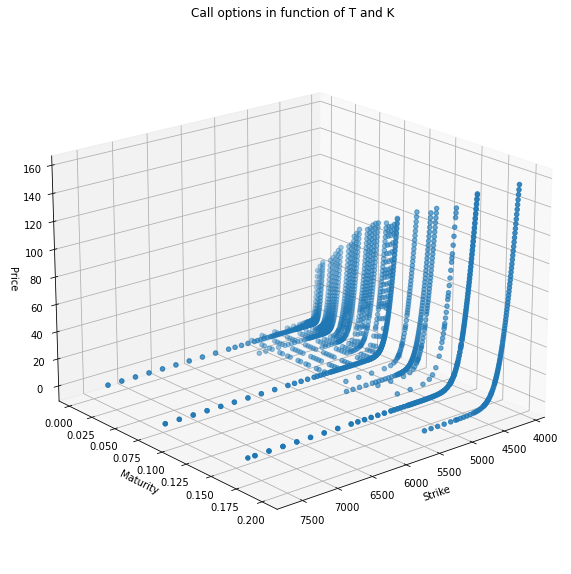

In [12]:
fig = plt.figure(figsize= [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Mid'])
ax.view_init(elev=20, azim=50)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Call options in function of T and K')

plt.show()

### 1.2 Put options

Now let us do the same for the puts options. Let us create the putPrices dataframe. 

In [13]:
putPrices = df[['Last Sale.1','Strike','Ask.1','Bid.1']]

putPrices["Mid.1"] = df[['Bid.1', 'Ask.1']].mean(axis=1)

# Convert dates to correct format
putPrices.index = pd.to_datetime(putPrices.index)

putPrices['Maturity.1'] = putPrices.index.to_series().apply(diff_func)
putPrices['Maturity.1'] = putPrices['Maturity.1']/365

putPrices = putPrices[putPrices['Strike']<=S0]

# Do not consider the start date
putPrices = putPrices[putPrices['Maturity.1']!=0]

Let us plot the data.

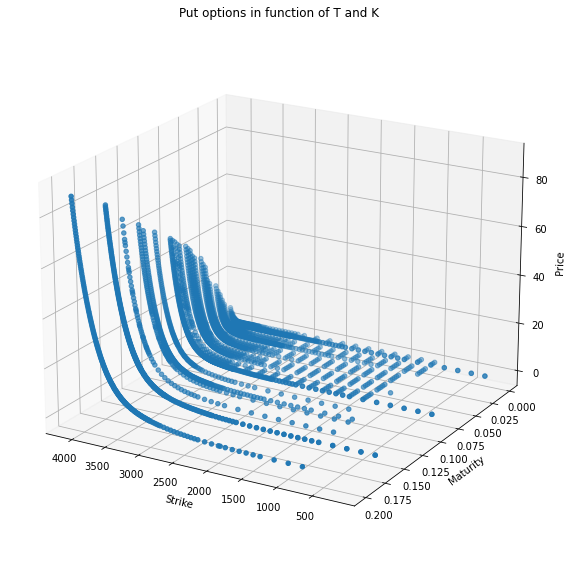

In [14]:
fig = plt.figure(figsize= [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(putPrices['Strike'], putPrices['Maturity.1'], putPrices['Mid.1'])
ax.view_init(elev=20, azim=120)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Put options in function of T and K')

plt.show()

### 1.3 Market prices

Let us build our matrix of market prices depending of the maturity and the strike. And also let us create a weights matrix (with weights inversely proportional to bid-ask spread).

In [15]:
strikes = np.sort(callPrices.Strike.unique())
maturities = np.sort(callPrices.Maturity.unique())

In [16]:
X,Y = np.meshgrid(strikes, maturities)
market_callPrices = np.empty([len(maturities), len(strikes)])

# Weights
w = np.empty([len(maturities), len(strikes)])

for i in range(len(maturities)):
    s = callPrices[callPrices.Maturity == maturities[i]]['Strike']
    price = callPrices[callPrices.Maturity == maturities[i]]['Mid']
    f = interpolate.interp1d(s, price, bounds_error = False, fill_value = 0)
    market_callPrices[i, :] = f(strikes)
    
    # Create weights matrix
    for j in range(len(strikes)):
        ask = callPrices[callPrices.Maturity == maturities[i]]['Ask'][0]
        bid = callPrices[callPrices.Maturity == maturities[i]]['Bid'][0]
        w[i,j] = 1/(ask-bid)

We can plot the market prices.

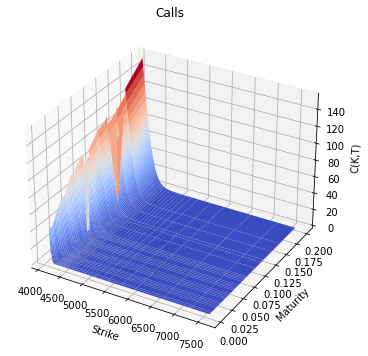

In [17]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, market_callPrices, cmap=cm.coolwarm)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('C(K,T)')

ax.set_title('Calls')

plt.show()

The problem here is that we have to many values and thus the optimization will take a long time so we will just take into account the values of T and K that are in the data.

In [18]:
strike_present = []

for j in maturities: 
        temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        strike_present.append(temp)

strikes = set(strike_present[0])
for i in range(1,len(strike_present)):
    strikes = strikes.intersection(set(strike_present[i]))

strikes = list(strikes)
strikes = sorted(strikes)

Let us calculate the market matrix.

In [19]:
market_callPrices = np.zeros((len(strikes), len(maturities)))


w = np.zeros((len(strikes), len(maturities)))

for j in range(len(maturities)):
    for i in range(len(strikes)):
        ask = callPrices[(callPrices.Maturity == maturities[j]) & (callPrices.Strike == strikes[i])]['Ask'][0]
        bid = callPrices[(callPrices.Maturity == maturities[j]) & (callPrices.Strike == strikes[i])]['Bid'][0]
        
        market_callPrices[i,j] = (ask + bid)/2
        
        w[i,j] = 1/(ask-bid)
        
market_callPrices = market_callPrices.T
w = w.T

We thus have a smaller matrix which allow to ease the optimization after.

## 2. Obtain Heston and VGSA parameters via calibration

First let us define couple of functions we will use later for the calibration.

In [20]:
# range for loops, from start, to finish with increment as the stepsize
def myRange(start, finish, increment):
    myZero = 1e-17
    while (start <= finish+myZero):
        yield start
        start += increment
        
        

# Periodic Linear Extension
def paramMapping(x, c, d):

    if ((x>=c) & (x<=d)):
        
        y = x

    else:
        
        range = d-c
        n = np.floor((x-c)/range)
        if (n%2 == 0):
            y = x - n*range;
        else:
            y = d + n*range - (x-c)
            
    return y

def calculate_dividend(C, P, S0, T, K, r):
    return -np.log(((C-P)+K*np.exp(-r*T))/S0)/T


def A_VG(u,t,kappa,eta,lambd):
    g = np.sqrt(kappa**2-2*1j*lambd**2*u)
    return np.exp(kappa**2*eta*t/lambd**2)/(np.cosh(g*t/2) + kappa/g*np.sinh(g*t/2))**(2*kappa*eta/lambd**2)

def B_VG(u,t,kappa,lambd):
    g = np.sqrt(kappa**2-2*1j*lambd**2*u)
    return 2*1j*u/(kappa + g/np.tanh(g*t/2))

def phi_italic_VG(u,t,y,kappa,eta,lambd):
    return A_VG(u,t,kappa,eta,lambd)*np.exp(B_VG(u,t,kappa,lambd)*y)

def psi_VG(u,theta,nu,sigma):
    return -1/nu*np.log(1-1j*u*theta*nu+sigma**2*nu*u**2/2)
        
def generic_CF(u, params, S0, r, q, T, model):
    
    if(model == 'Heston'):
        
        kappa  = params[0]
        theta  = params[1]
        sigma  = params[2]
        rho    = params[3]
        v0     = params[4]
        
        kappa = paramMapping(kappa,0.1, 20)
        theta = paramMapping(theta,0.001, 0.4)
        sigma = paramMapping(sigma,0.01, 0.6)
        rho   = paramMapping(rho  ,-1.0, 1.0)
        v0    = paramMapping(v0   ,0.005, 0.25)
        
        g = np.sqrt((kappa-1j*rho*sigma*u)**2+(u**2+1j*u)*sigma**2)
        beta = kappa-rho*sigma*1j*u
        tmp = g*T/2
        
        temp1 = 1j*(np.log(S0)+(r-q)*T)*u + kappa*theta*T*beta/(sigma**2)
        temp2 = -(u**2+1j*u)*v0/(g/np.tanh(tmp)+beta)
        temp3 = (2*kappa*theta/(sigma**2))*np.log(np.cosh(tmp)+(beta/g)*np.sinh(tmp))
        
        phi = np.exp(temp1+temp2-temp3)
        

    elif (model == 'VGSA'):
                
        sigma  = params[0]
        nu     = params[1]
        theta  = params[2]
        kappa  = params[3]
        eta    = params[4]
        lambd  = params[5]

        phi = np.exp(1j*u*(np.log(S0) + (r - q)*T))*phi_italic_VG(-1j*psi_VG(u,theta,nu,sigma),T,1/nu,kappa,eta,lambd)/phi_italic_VG(-1j*psi_VG(-1j,theta,nu,sigma),T,1/nu,kappa,eta,lambd)**(1j*u)

    return phi

def genericFFT(params, S0, K, r, q, T, alpha, eta, n, model):
    
    N = 2**n
    
    # step-size in log strike space
    lda = (2*np.pi/N)/eta
    
    #Choice of beta
    #beta = np.log(S0)-N*lda/2
    beta = np.log(K)
    
    # forming vector x and strikes km for m=1,...,N
    km = np.zeros((N))
    xX = np.zeros((N))
    
    # discount factor
    df = np.exp(-r*T)
    
    nuJ = np.arange(N)*eta
    psi_nuJ = generic_CF(nuJ-(alpha+1)*1j, params, S0, r, q, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
    
    for j in range(N):  
        km[j] = beta+j*lda
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        xX[j] = np.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ
     
    yY = np.fft.fft(xX)
    cT_km = np.zeros((N))  
    for i in range(N):
        multiplier = np.exp(-alpha*km[i])/np.pi
        cT_km[i] = multiplier*np.real(yY[i])
    
    return km, cT_km

In [21]:
def eValue(params, *args):
   
    marketPrices = args[0]
    maturities = args[1]
    strikes = args[2]
    r = args[3]
    q = args[4]
    S0 = args[5]
    alpha = args[6]
    eta = args[7]
    n = args[8]
    model = args[9]
    weight_bool = args[10]

    lenT = len(maturities)
    lenK = len(strikes)
   
    modelPrices = np.zeros((lenT, lenK))

    count = 0
    mae = 0
    for i in range(lenT):
        for j in range(lenK):
            count  = count+1
            T = maturities[i]
            K = strikes[j]
            
            [km, cT_km] = genericFFT(params, S0, K, r, q, T, alpha, eta, n, model)
            modelPrices[i,j] = cT_km[0]

            tmp = marketPrices[i,j]-modelPrices[i,j]
            if weight_bool:
                mae += w[i,j]*tmp**2
            else:
                mae += tmp**2
   
    rmse = math.sqrt(mae/count)
    return rmse

### 2.1 Heston model

Let us define the parameters. We choose n = 8 as it allows to avoid a slow computation and it gives a good estimation of our parameters. The parameters of the Heston model are the following: $\kappa$, $\theta$, $\sigma$, $\rho$ and $v_0$.

In [22]:
model ='Heston'
n = 8

#### 2.1.2 With equal weights

Let us first do a rough grid search to have an idea of the parameters to use.

In [23]:
weight_bool = 0


ind_iter = 1
rmseMin = 1e6

start_time = time.time()

params_a = np.array([ 3.282, -0.0025,  -1.169, 1.188, 0.945])

min_range = -1.1
max_range = 1.1
step = 0.1

for coef in myRange(min_range,max_range,step):
    params = coef*params_a

    print('i = ' + str(ind_iter) + '/' + str(int((max_range-min_range)/step)+1))
    ind_iter += 1
    rmse = eValue(params, market_callPrices, maturities, strikes,r, q, S0, alpha, eta, n, model, weight_bool)              
    if (rmse < rmseMin):
        rmseMin = rmse
        params2 = params
        print('\nnew min found')
        print(rmseMin)
        print(params2)
        print('')
                    


print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

i = 1/23

new min found
23.305505762917356
[-3.6102e+00  2.7500e-03  1.2859e+00 -1.3068e+00 -1.0395e+00]

i = 2/23

new min found
6.087213617405774
[-3.282e+00  2.500e-03  1.169e+00 -1.188e+00 -9.450e-01]

i = 3/23
i = 4/23
i = 5/23
i = 6/23
i = 7/23
i = 8/23
i = 9/23
i = 10/23
i = 11/23
i = 12/23
i = 13/23
i = 14/23
i = 15/23
i = 16/23
i = 17/23
i = 18/23
i = 19/23
i = 20/23
i = 21/23
i = 22/23
i = 23/23

Solution of grid search:
[-3.282e+00  2.500e-03  1.169e+00 -1.188e+00 -9.450e-01]
Optimal rmse = 6.087213617405774
Execution time was 10.5659878 seconds


Let us be more precise now by using the fmin_bfgs function of scipy.

In [24]:
def print_value(x):
    global iter_
    global args
    print(' ')
    print('i = ' + str(iter_))
    print('params = ' + str(x))
    print('rmse = ' + str(eValue(x, *args)))
    iter_ += 1

In [25]:
start_time = time.time()

params = params2

iter_ = 1

args = (market_callPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, weight_bool)

[param_heston, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(eValue,params,args=args, fprime=None,callback=print_value,maxiter=5,full_output=True, retall=False)


elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

 
i = 1
params = [-3.28199560e+00  3.06715453e-03  1.16898411e+00 -1.18799932e+00
 -9.42809719e-01]
rmse = 5.801033381595773
 
i = 2
params = [-3.28188562  0.01822897  1.16550134 -1.18786279 -0.94568258]
rmse = 5.66183325765472
 
i = 3
params = [-3.28044426  0.02143943  0.81301931 -1.17269232 -0.94360482]
rmse = 4.439534454826257
 
i = 4
params = [-3.28831945  0.02288753  0.72056245 -1.06913157 -0.94305647]
rmse = 4.204609193243117
 
i = 5
params = [-3.46380607  0.03136392  0.60618927 -1.02394571 -0.94234307]
rmse = 3.7906522841908075
         Current function value: 3.790652
         Iterations: 5
         Function evaluations: 78
         Gradient evaluations: 13
Execution time was 37.8295937 seconds


The best parameters for Heston are the following:

In [26]:
print(param_heston)

[-3.46380607  0.03136392  0.60618927 -1.02394571 -0.94234307]


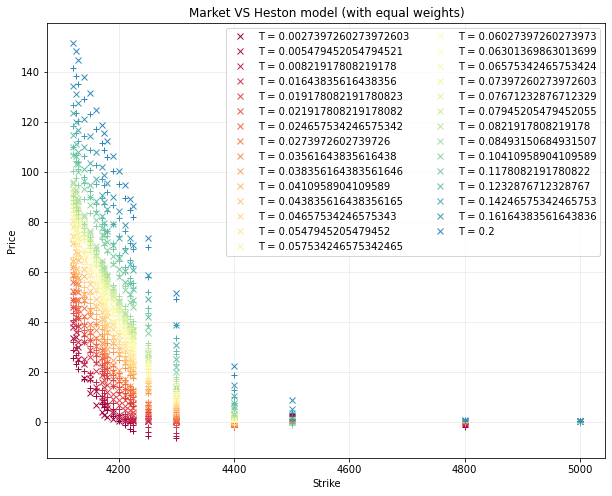

In [27]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices_heston = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = genericFFT(param_heston, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_heston[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

plt.gca().set_prop_cycle(color = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, market_callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_heston[i,:], '+')
    
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market VS Heston model (with equal weights)')
plt.show() 

Let us plot a call option premium surface for various strikes and maturities.

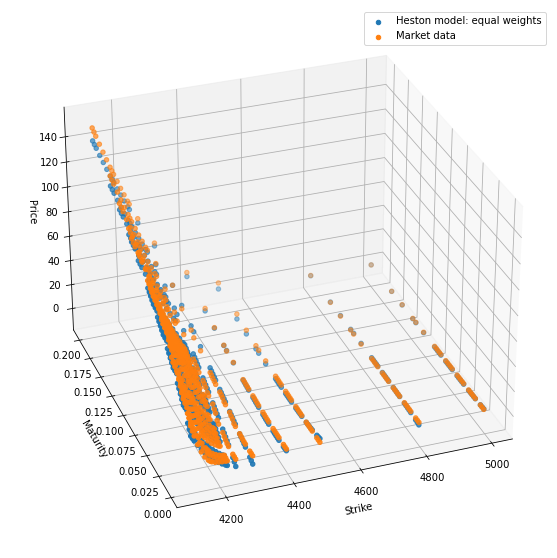

In [28]:
X, Y = np.meshgrid(maturities, strikes)

X_flat = X.flatten()
Y_flat =  Y.flatten()
prices_flat =  market_callPrices.flatten()


fig = plt.figure(figsize= [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_flat, X_flat, modelPrices_heston.T, label='Heston model: equal weights')
ax.scatter(Y, X, market_callPrices.T, label='Market data')

ax.view_init(elev=30, azim=250)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.legend()

plt.show()

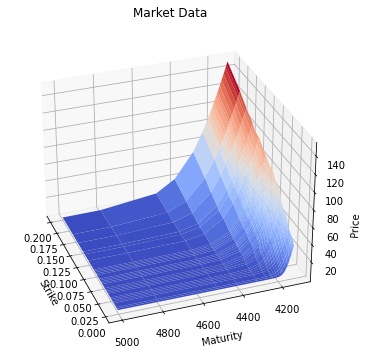

In [29]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, market_callPrices.T, cmap=cm.coolwarm)
ax.view_init(elev=30, azim=160)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Market Data')

plt.show()

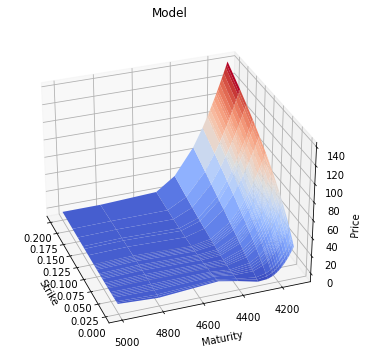

In [30]:
fig1 = plt.figure(figsize = (8,6))

ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot_surface(X, Y, modelPrices_heston.T, cmap=cm.coolwarm)
ax1.view_init(elev=30, azim=160)

ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')

ax1.set_title('Model')

plt.show()

We can thus notice that the model prediction is pretty good.

#### 2.1.2 With weights inversely proportional to bid-ask spread

Let us first do a rough grid search to have an idea of the parameters to use.

In [31]:
weight_bool = 1


ind_iter = 1
rmseMin = 1e6

start_time = time.time()

params_a = np.array([ 3.282, -0.0025,  -1.169, 1.188, 0.945])

min_range = -1.1
max_range = 1.1
step = 0.1

for coef in myRange(min_range,max_range,step):
    params = coef*params_a

    print('i = ' + str(ind_iter) + '/' + str(int((max_range-min_range)/step)+1))
    ind_iter += 1
    rmse = eValue(params, market_callPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, weight_bool)              
    if (rmse < rmseMin):
        rmseMin = rmse
        params2 = params
        print('\nnew min found')
        print(rmseMin)
        print(params2)
        print('')
                    


print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

i = 1/23

new min found
26.688281278669248
[-3.6102e+00  2.7500e-03  1.2859e+00 -1.3068e+00 -1.0395e+00]

i = 2/23

new min found
6.842450877969659
[-3.282e+00  2.500e-03  1.169e+00 -1.188e+00 -9.450e-01]

i = 3/23
i = 4/23
i = 5/23
i = 6/23
i = 7/23
i = 8/23
i = 9/23
i = 10/23
i = 11/23
i = 12/23
i = 13/23
i = 14/23
i = 15/23
i = 16/23
i = 17/23
i = 18/23
i = 19/23
i = 20/23
i = 21/23
i = 22/23
i = 23/23

Solution of grid search:
[-3.282e+00  2.500e-03  1.169e+00 -1.188e+00 -9.450e-01]
Optimal rmse = 6.842450877969659
Execution time was 10.7925849 seconds


Let us be more precise now by using the fmin_bfgs function of scipy.

In [32]:
start_time = time.time()

params = params2

iter_ = 1

args = (market_callPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, weight_bool)


[param_heston_w, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(eValue,params,args=args, fprime=None,callback=print_value,maxiter=5,full_output=True, retall=False)


elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

 
i = 1
params = [-3.28199710e+00  2.88867637e-03  1.16893352e+00 -1.18799737e+00
 -9.44261935e-01]
rmse = 6.836014692014611
 
i = 2
params = [-3.28197105  0.00653026  1.16783947 -1.18795433 -0.94492385]
rmse = 6.77859980153217
 
i = 3
params = [-3.28212758  0.00849005  1.05253187 -1.18280162 -0.94426837]
rmse = 6.232091716570327
 
i = 4
params = [-3.27997795  0.01287754  0.83844365 -1.00757254 -0.94312729]
rmse = 5.3042252325200625
 
i = 5
params = [-3.36412701  0.0253558   0.70797591 -0.89368783 -0.9431655 ]
rmse = 4.923071017516608
         Current function value: 4.923071
         Iterations: 5
         Function evaluations: 66
         Gradient evaluations: 11
Execution time was 32.9324410 seconds


The best parameters for Heston are the following:

In [33]:
print(param_heston_w)

[-3.36412701  0.0253558   0.70797591 -0.89368783 -0.9431655 ]


Let us plot the results.

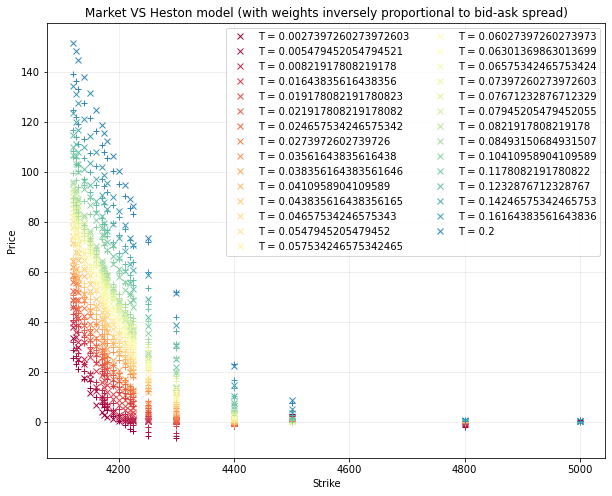

In [34]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices_heston_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = genericFFT(param_heston_w, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_heston_w[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

plt.gca().set_prop_cycle(color = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, market_callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_heston_w[i,:], '+')
    
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market VS Heston model (with weights inversely proportional to bid-ask spread)')
plt.show() 

We can thus notice that the Heston model with the weights inversely proportional to bid-ask spread is less accurate (rmse = 4.92) than with equal weights (rmse = 3.79).

Let us plot the call option premium surface anyway.

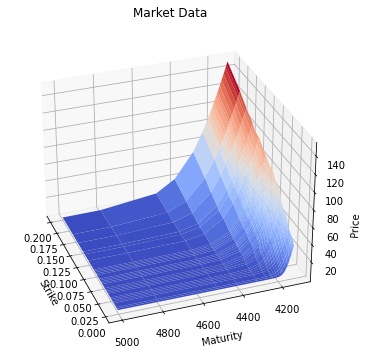

In [35]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, market_callPrices.T, cmap=cm.coolwarm)
ax.view_init(elev=30, azim=160)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Market Data')

plt.show()

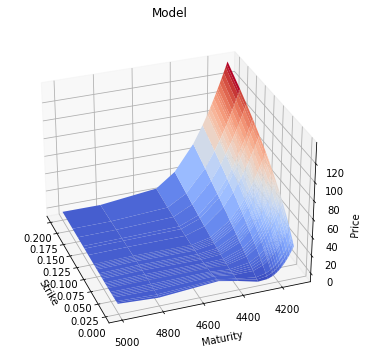

In [36]:
fig1 = plt.figure(figsize = (8,6))

ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot_surface(X, Y, modelPrices_heston_w.T, cmap=cm.coolwarm)
ax1.view_init(elev=30, azim=160)

ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')

ax1.set_title('Model')

plt.show()

#### 2.1.3 Comparison

As said previously the Heston Model with equal weights is a bit more precise than with weights inversely proportional to bid-ask spread.

We can compare the parameters obtained for both methods.

In [37]:
print('Equal weights:')
print(param_heston)
print('Weights inversely proportional to bid-ask spread:')
print(param_heston_w)

Equal weights:
[-3.46380607  0.03136392  0.60618927 -1.02394571 -0.94234307]
Weights inversely proportional to bid-ask spread:
[-3.36412701  0.0253558   0.70797591 -0.89368783 -0.9431655 ]


We can notice that the parameters are not very different from each other.

### 2.2 VGSA model

For this model we will follow the same logic as the one done for the Heston model.

Let us define the parameters. We choose n = 8 as it allows to avoid a slow computation and it gives a good estimation of our parameters. The parameters of the VGSA model are the following: $\sigma$, $\nu$, $\theta$, $\kappa$, $\eta$ and $\lambda$.

In [38]:
model = 'VGSA'
n = 8

#### 2.2.1 With equal weights

First, we do a rough estimation.

In [39]:
weight_bool = 0


ind_iter = 1
rmseMin = 1e6

start_time = time.time()

params_a = np.array([ 0.052,  0.075, -0.044,  2.540,  0.940, 0.989 ])

min_range = -1.1
max_range = 1.1
step = 0.1

for coef in myRange(min_range,max_range,step):
    params = coef*params_a

    print('i = ' + str(ind_iter) + '/' + str(int((max_range-min_range)/step)+1))
    ind_iter += 1
    rmse = eValue(params, market_callPrices, maturities, strikes,r, q, S0, alpha, eta, n, model, weight_bool)              
    if (rmse < rmseMin):
        rmseMin = rmse
        params2 = params
        print('\nnew min found')
        print(rmseMin)
        print(params2)
        print('')
                    


print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

i = 1/23

new min found
124231.1363481027
[-0.0572 -0.0825  0.0484 -2.794  -1.034  -1.0879]

i = 2/23

new min found
35254.54275849619
[-0.052 -0.075  0.044 -2.54  -0.94  -0.989]

i = 3/23

new min found
6701.064994224451
[-0.0468 -0.0675  0.0396 -2.286  -0.846  -0.8901]

i = 4/23

new min found
1311.8000604561357
[-0.0416 -0.06    0.0352 -2.032  -0.752  -0.7912]

i = 5/23

new min found
465.549553472891
[-0.0364 -0.0525  0.0308 -1.778  -0.658  -0.6923]

i = 6/23

new min found
243.06031982920118
[-0.0312 -0.045   0.0264 -1.524  -0.564  -0.5934]

i = 7/23

new min found
147.38795151965613
[-0.026  -0.0375  0.022  -1.27   -0.47   -0.4945]

i = 8/23

new min found
101.9086668065882
[-0.0208 -0.03    0.0176 -1.016  -0.376  -0.3956]

i = 9/23

new min found
77.55037556916905
[-0.0156 -0.0225  0.0132 -0.762  -0.282  -0.2967]

i = 10/23

new min found
62.36672233940646
[-0.0104 -0.015   0.0088 -0.508  -0.188  -0.1978]

i = 11/23

new min found
51.600066053957015
[-0.0052 -0.0075  0.0044 -0.2

Let us be more precise now by using the fmin_bfgs function of scipy.

In [40]:
start_time = time.time()

params = params2

iter_ = 1

args = (market_callPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, weight_bool)


[param_VGSA, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(eValue,params,args=args, fprime=None,callback=print_value,maxiter=5,full_output=True, retall=False)


elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

 
i = 1
params = [ 0.05112091  0.07532674 -0.0439845   2.54000099  0.93999978  0.98900005]
rmse = 5.512105104377274
 
i = 2
params = [ 0.05218605  0.08215178 -0.06947378  2.53991252  0.94002433  0.989092  ]
rmse = 5.313256488888948
 
i = 3
params = [ 0.05323421  0.08499674 -0.06904993  2.5400165   0.93998342  0.98915968]
rmse = 5.311290605442641
 
i = 4
params = [ 0.05320445  0.08556531 -0.07166649  2.54451675  0.93802714  0.99160702]
rmse = 5.292812656188728
 
i = 5
params = [ 0.05423234  0.09312183 -0.08418497  2.60117045  0.91134436  1.0165812 ]
rmse = 5.142636118449924
         Current function value: 5.142636
         Iterations: 5
         Function evaluations: 84
         Gradient evaluations: 12
Execution time was 42.9872169 seconds


The best parameters for VGSA are the following:

In [41]:
print(param_VGSA)

[ 0.05423234  0.09312183 -0.08418497  2.60117045  0.91134436  1.0165812 ]


Let us plot the results

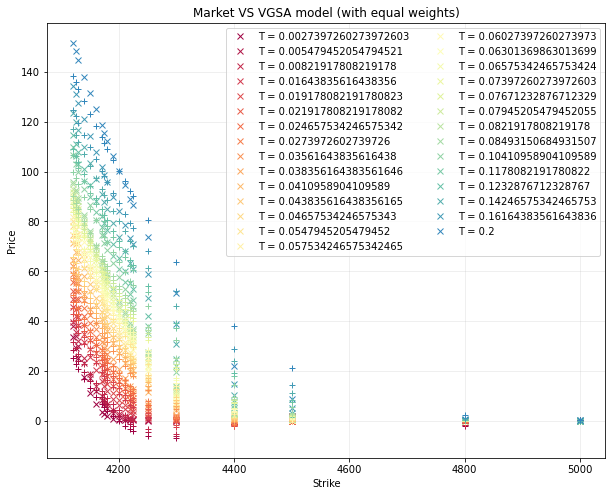

In [42]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices_VGSA = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = genericFFT(param_VGSA, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_VGSA[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

plt.gca().set_prop_cycle(color = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, market_callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_VGSA[i,:], '+')
    
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market VS VGSA model (with equal weights)')
plt.show() 

We can notice that estimation is good but not as good as the Heston model with equal weights.

Let us plot the call option surface

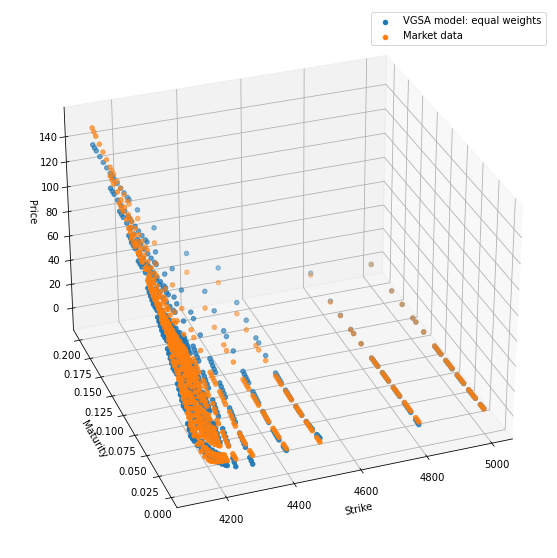

In [43]:
X, Y = np.meshgrid(maturities, strikes)

X_flat = X.flatten()
Y_flat =  Y.flatten()
prices_flat =  market_callPrices.flatten()


fig = plt.figure(figsize= [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_flat, X_flat, modelPrices_VGSA.T, label='VGSA model: equal weights')
ax.scatter(Y, X, market_callPrices.T, label='Market data')

ax.view_init(elev=30, azim=250)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.legend()

plt.show()

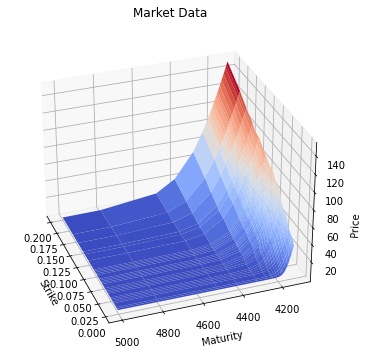

In [44]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, market_callPrices.T, cmap=cm.coolwarm)
ax.view_init(elev=30, azim=160)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Market Data')

plt.show()

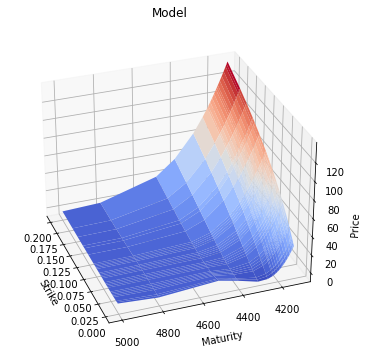

In [45]:
fig1 = plt.figure(figsize = (8,6))

ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot_surface(X, Y, modelPrices_VGSA.T, cmap=cm.coolwarm)
ax1.view_init(elev=30, azim=160)

ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')

ax1.set_title('Model')

plt.show()

#### 2.2.2 With weights inversely proportional to bid-ask spread

We do the same as before but this time with weights inversely proportional to bid-ask spread.

In [46]:
weight_bool = 1


ind_iter = 1
rmseMin = 1e6

start_time = time.time()

params_a = np.array([ 0.052,  0.075, -0.044,  2.540,  0.940, 0.989 ])

min_range = -1.1
max_range = 1.1
step = 0.1

for coef in myRange(min_range,max_range,step):
    params = coef*params_a

    print('i = ' + str(ind_iter) + '/' + str(int((max_range-min_range)/step)+1))
    ind_iter += 1
    rmse = eValue(params, market_callPrices, maturities, strikes,r, q, S0, alpha, eta, n, model, weight_bool)              
    if (rmse < rmseMin):
        rmseMin = rmse
        params2 = params
        print('\nnew min found')
        print(rmseMin)
        print(params2)
        print('')
                    


print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

i = 1/23

new min found
125619.94220044304
[-0.0572 -0.0825  0.0484 -2.794  -1.034  -1.0879]

i = 2/23

new min found
36414.05216600393
[-0.052 -0.075  0.044 -2.54  -0.94  -0.989]

i = 3/23

new min found
7205.195152366355
[-0.0468 -0.0675  0.0396 -2.286  -0.846  -0.8901]

i = 4/23

new min found
1442.0388147213005
[-0.0416 -0.06    0.0352 -2.032  -0.752  -0.7912]

i = 5/23

new min found
479.21372684511834
[-0.0364 -0.0525  0.0308 -1.778  -0.658  -0.6923]

i = 6/23

new min found
239.31999095474168
[-0.0312 -0.045   0.0264 -1.524  -0.564  -0.5934]

i = 7/23

new min found
142.9897992802543
[-0.026  -0.0375  0.022  -1.27   -0.47   -0.4945]

i = 8/23

new min found
98.78778710237131
[-0.0208 -0.03    0.0176 -1.016  -0.376  -0.3956]

i = 9/23

new min found
75.56869719679247
[-0.0156 -0.0225  0.0132 -0.762  -0.282  -0.2967]

i = 10/23

new min found
61.141294168425844
[-0.0104 -0.015   0.0088 -0.508  -0.188  -0.1978]

i = 11/23

new min found
50.83206871672817
[-0.0052 -0.0075  0.0044 -0

In [47]:
start_time = time.time()

params = params2

iter_ = 1

args = (market_callPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, weight_bool)


[param_VGSA_w, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(eValue,params,args=args, fprime=None,callback=print_value,maxiter=5,full_output=True, retall=False)


elapsed_time = time.time() - start_time
print('Execution time was %0.7f seconds' % elapsed_time)

 
i = 1
params = [ 0.04714868  0.06738164 -0.03964818  2.28599956  0.84600008  0.89010012]
rmse = 6.6108774284923815
 
i = 2
params = [ 0.04778264  0.0717462  -0.06039239  2.28596224  0.8460086   0.89016375]
rmse = 6.423008842147402
 
i = 3
params = [ 0.05075625  0.08045641 -0.06396382  2.28605656  0.84598662  0.89024052]
rmse = 6.3852335712484996
 
i = 4
params = [ 0.04977482  0.07973818 -0.07435846  2.31207633  0.83757471  0.89816494]
rmse = 6.332419241458887
 
i = 5
params = [ 0.05154689  0.08718877 -0.08184617  2.37237348  0.81644765  0.90792168]
rmse = 6.2449422140563975
         Current function value: 6.244942
         Iterations: 5
         Function evaluations: 84
         Gradient evaluations: 12
Execution time was 43.0227871 seconds


The best parameters for VGSA (with weights inversely proportional to bid-ask spread) are the following:

In [48]:
print(param_VGSA_w)

[ 0.05154689  0.08718877 -0.08184617  2.37237348  0.81644765  0.90792168]


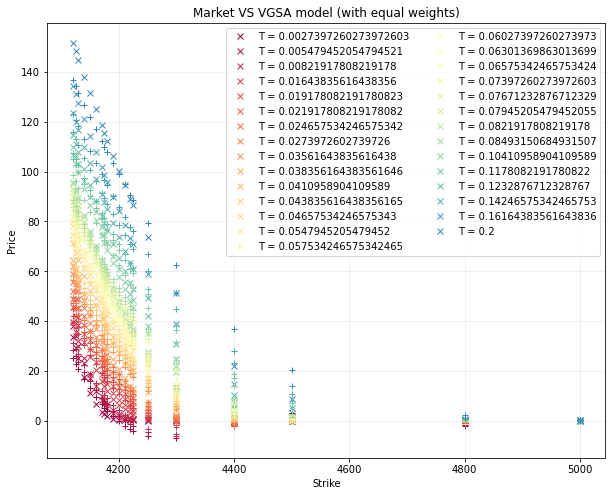

In [49]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices_VGSA_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = genericFFT(param_VGSA_w, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_VGSA_w[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral

plt.gca().set_prop_cycle(color = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, market_callPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_VGSA_w[i,:], '+')
    
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market VS VGSA model (with equal weights)')
plt.show() 

The results are still quite ok but they were better by using equal weights.

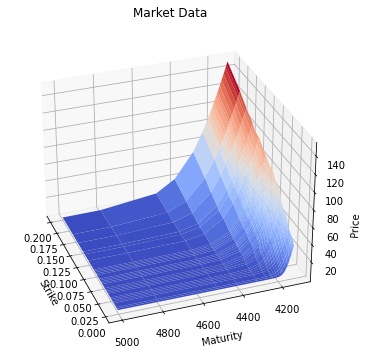

In [50]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, market_callPrices.T, cmap=cm.coolwarm)
ax.view_init(elev=30, azim=160)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

ax.set_title('Market Data')

plt.show()

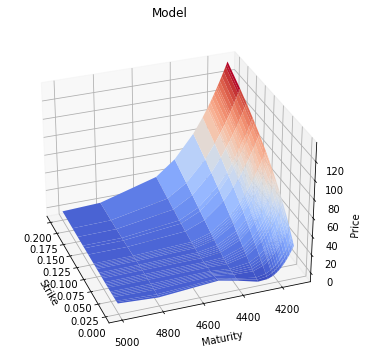

In [51]:
fig1 = plt.figure(figsize = (8,6))

ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot_surface(X, Y, modelPrices_VGSA_w.T, cmap=cm.coolwarm)
ax1.view_init(elev=30, azim=160)

ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')

ax1.set_title('Model')

plt.show()

#### 2.2.3 Comparison

So we obtain the following parameters for each methods.

In [52]:
print('Equal weights:')
print(param_VGSA)
print('Weights inversely proportional to bid-ask spread:')
print(param_VGSA_w)

Equal weights:
[ 0.05423234  0.09312183 -0.08418497  2.60117045  0.91134436  1.0165812 ]
Weights inversely proportional to bid-ask spread:
[ 0.05154689  0.08718877 -0.08184617  2.37237348  0.81644765  0.90792168]


We can also notice that the parameters are not very different from each other.

In conclusion, we can notice that all the models produce correct estimations even if they are not perfectly accurate. In addition, we can conclude that the best model obtained here is the Heston model with equal weights with a rmse of 3.79.

## 3 Local volatility

Let us define the function to plot the volatility.

In [53]:
def volatility(prices, K, T):
    # Calculate local volatilities
    sig_array = [0.2]
    sig_loc = np.zeros_like(prices)
    for i in range(1, len(K)-1):
        for j in range(1, len(T)-1):
            dC_dt = (prices[i,j+1] - prices[i,j-1]) / (T[j+1] - T[j-1])
            dC_dK = (prices[i+1,j] - prices[i-1,j]) / (K[i+1] - K[i-1])
            dC2_dK2 = (prices[i+1,j] - 2 * prices[i,j] + prices[i-1,j]) /((K[i+1] - K[i]) * (K[i] - K[i-1]))
            sig = np.sqrt(2 * (dC_dt + q*prices[i,j] + (r-q)*K[i]*dC_dK) / (K[i]**2 * dC2_dK2))
            if 0.1 < sig < 0.96:
                sig_loc[i,j] = sig
                sig_array += [sig]
            else:
                sig_loc[i,j] = sig_loc[i,j-1]
                sig_array += [sig_array[i-1]]
    
    # Interpolate local volatilities to a grid and plot
    strikes_ = Y
    maturities_ = X
    x = strikes_.flatten()[:len(sig_array)]
    y = maturities_.flatten()[:len(sig_array)]
    z = sig_array
    interpolator = interpolate.CloughTocher2DInterpolator(np.array([x,y]).T, z)
    xline = np.linspace(min(x), max(x), 50)
    yline = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)
    xgrid, ygrid = np.meshgrid(xline, yline)
    z_interp = interpolator(xgrid, ygrid)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xgrid, ygrid, z_interp, cmap='viridis', vmin=min(z), vmax=max(z))
    ax.view_init(elev=20, azim=160)
    ax.plot(x, y, z, 'ro')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Local Volatility')
    ax.set_zlim([0,1.5])
    plt.show()


Heston with equal weights.

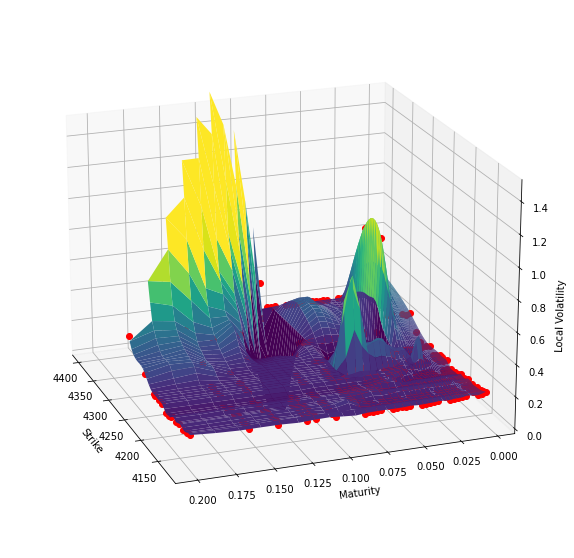

In [54]:
volatility(modelPrices_heston.T, strikes,maturities)

Heston with weights inversely proportional to bid-ask spread.

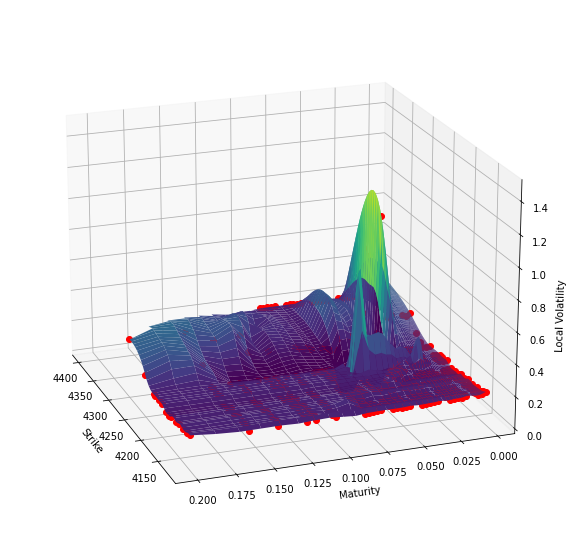

In [55]:
volatility(modelPrices_heston_w.T, strikes,maturities)

VGSA with equal weights.

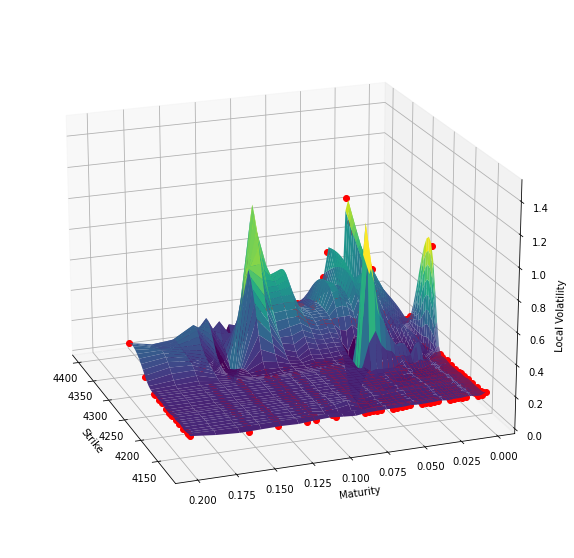

In [56]:
volatility(modelPrices_VGSA.T, strikes,maturities)

VGSA with weights inversely proportional to bid-ask spread.

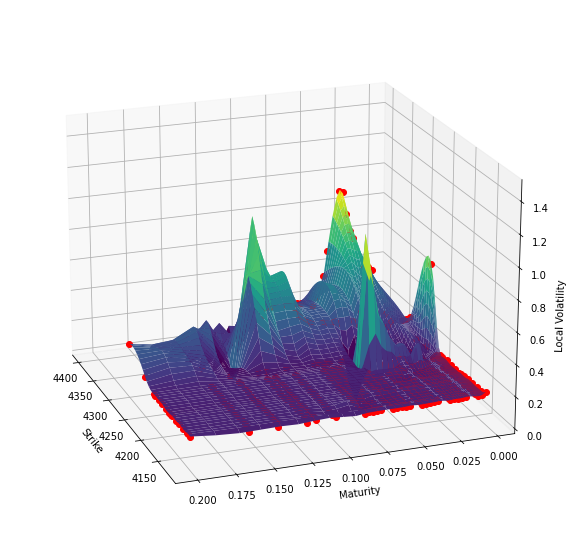

In [57]:
volatility(modelPrices_VGSA_w.T, strikes,maturities)

We can notice that using weights inversely proportional to bid-ask spread smooths the volatility surface.

## 4 Comparison between Heston and VGSA volatility

While the VGSA model permits a fluctuating correlation, the Heston model requires a constant connection between the underlying asset and its volatility. This means that the implied volatility surface, which is crucial in pricing options, can be more accurately represented by the VGSA model and can capture more complicated patterns in the local volatility surface. This indeed what we can observe on the figures above. The local volatility surface of the VGSA model is more complex that the one of the Heston and capture more patterns.

The VGSA model's versatility comes at a price, since it could need more computational resources and model calibration skills than the Heston model, which is more straightforward and straightforward to calibrate. The underlying asset's non-normality and skewness, however, can be better captured by the VGSA model, which is particularly helpful for pricing exotic options with intricate payout structures.

Despite the advantages of the VGSA model, the Heston model is frequently employed in practice since it is straightforward and straightforward to calibrate to market data. The exact application, the availability, and the caliber of the data all influence which of the Heston and VGSA models should be used.